In [1]:
#import statements
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import svm
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
import pickle
from time import time

In [2]:
#Read in the lemmatized data
smallData = pd.read_csv("lemmatizedArticles.csv")

In [3]:
#Use only articles of sizable length
minLemmaLen = 100
smallerData = smallData[smallData["len"]>minLemmaLen]

In [4]:
#Split articles into their respective bias categories
vr = smallerData[smallerData["Rating"]==2]
sr = smallerData[smallerData["Rating"]==1]
c = smallerData[smallerData["Rating"]==0]
sl = smallerData[smallerData["Rating"]==-1]
vl = smallerData[smallerData["Rating"]==-2]
print("Number of Very Right articles: ",len(vr))
print("Number of Slightly Right articles: ",len(sr))
print("Number of Center Articles: ",len(c))
print("Number of Slightly Left articles: ",len(sl))
print("Number of Very Left articles: ",len(vl))


Number of Very Right articles:  51111
Number of Slightly Right articles:  39317
Number of Center Articles:  21734
Number of Slightly Left articles:  32076
Number of Very Left articles:  28862


In [5]:
#Get an equal subset from each category
sn=min(len(vr),len(sr),len(c),len(sl),len(vl))
newData = pd.concat([vr.sample(n=sn),sr.sample(n=sn),c.sample(n=sn),sl.sample(n=sn),vl.sample(n=sn)])
print("Total number of articles analyzed: ",len(newData)," (",len(newData)/5," per category )")

Total number of articles analyzed:  108670  ( 21734.0  per category )


In [6]:
#Function to rejoin all our lemmatized words into a string
def proc(tex):
    temp = tex[2:-2].split("', '")
    return " ".join(temp)

newData['updatedLem'] = newData["lemText"].apply(proc)
#Get our X values and y values. 
X = newData['updatedLem']
#First, try to put all articles in the proper of the 5 categories
y = (newData['Rating'])

In [7]:
#Bag of words analysis
transModel = CountVectorizer()
transModel.fit(X)
bow_transformer=transModel.transform(X)
#Split into training and testing sets (testing is 10%)
X_train, X_test, y_train, y_test = train_test_split(bow_transformer, y
                                  ,test_size=0.1, random_state=1234)

In [8]:
#save countvectorizer
pickle.dump(transModel,open('simpleWebApp/countVectorizerModel.sav','wb'))

In [10]:
#Training set is currently too unwieldy, take only 30% of it. Still takes hours to train!
X_other, X_small, y_other, y_small = train_test_split(X_train, y_train
                                  ,test_size=0.3, random_state=123)

In [12]:
#Scan over parameter space for the SVC
#First, take a much smaller subset to test on
X_other2, X_small_train, y_other2, y_small_train = train_test_split(X_other, y_other
                                  ,test_size=0.1, random_state=12)
_, X_small_test, _, y_small_test = train_test_split(X_other2, y_other2
                                  ,test_size=0.1, random_state=1)
#Now scan over the space and pick the best parameters for gamma and C
firstBestScore = 0
firstBestC = 0
firstBestGamma = 0
for C in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]:
    for gamma in [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,10,100,1000,10000]:
        print(C,gamma)
        model = svm.SVC(C=C, kernel='rbf', gamma=gamma)
        model.fit(X_small_train, y_small_train)
        score = model.score(X_small_test, y_small_test)
        
        if score > firstBestScore:
            firstBestC = C
            firstBestGamma = gamma
            firstBestScore = score
            print("*"+str(score))
        else:
            print(score)
print("--------")
print("Best C value: ",firstBestC)
print("Best Gamma value: ",firstBestGamma)
print("Best score: ", firstBestScore)

1e-06 1e-06
*0.19330855018587362
1e-06 1e-05
0.19330855018587362
1e-06 0.0001
0.19330855018587362
1e-06 0.001
0.19330855018587362
1e-06 0.01
0.19330855018587362
1e-06 0.1
0.19330855018587362
1e-06 1
0.19330855018587362
1e-06 10
0.19330855018587362
1e-06 100
0.19330855018587362
1e-06 1000
0.19330855018587362
1e-06 10000
0.19330855018587362
1e-05 1e-06
0.19330855018587362
1e-05 1e-05
0.19330855018587362
1e-05 0.0001
0.19330855018587362
1e-05 0.001
0.19330855018587362
1e-05 0.01
0.19330855018587362
1e-05 0.1
0.19330855018587362
1e-05 1
0.19330855018587362
1e-05 10
0.19330855018587362
1e-05 100
0.19330855018587362
1e-05 1000
0.19330855018587362
1e-05 10000
0.19330855018587362
0.0001 1e-06
0.19330855018587362
0.0001 1e-05
0.19330855018587362
0.0001 0.0001
0.19330855018587362
0.0001 0.001
0.19330855018587362
0.0001 0.01
0.19330855018587362
0.0001 0.1
0.19330855018587362
0.0001 1
0.19330855018587362
0.0001 10
0.19330855018587362
0.0001 100
0.19330855018587362
0.0001 1000
0.19330855018587362
0

In [11]:
model = svm.SVC(C=10, kernel='rbf', gamma=1e-3,verbose=1)
t1 = time()
model.fit(X_small, y_small)
print(time()-t1)

[LibSVM]7159.330421924591


In [12]:
print(model.score(X_test,y_test))

0.6915432041961903


              precision    recall  f1-score   support

          -2       0.73      0.74      0.74      2238
          -1       0.72      0.72      0.72      2141
           0       0.70      0.71      0.71      2181
           1       0.58      0.64      0.61      2120
           2       0.74      0.65      0.69      2187

    accuracy                           0.69     10867
   macro avg       0.69      0.69      0.69     10867
weighted avg       0.69      0.69      0.69     10867

Confusion Matrix:
[[0.73994638 0.05406613 0.07327971 0.09428061 0.03842717]
 [0.06585708 0.71648762 0.06959365 0.10088744 0.04717422]
 [0.07152682 0.07748739 0.70976616 0.09857863 0.04264099]
 [0.08396226 0.07688679 0.09669811 0.63867925 0.10377358]
 [0.06218564 0.06858711 0.0608139  0.15775034 0.65066301]]


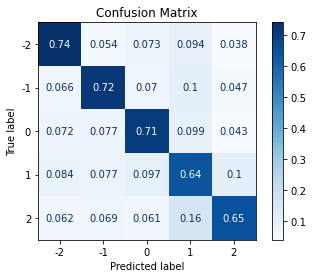

In [13]:
predictions = model.predict(X_test)
# getting the Precision, Recall, F1-Score
print(classification_report(y_test,predictions))
disp = plot_confusion_matrix(model, X_test, y_test,
                                 display_labels=[-2,-1,0,1,2],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
title="Confusion Matrix"
disp.ax_.set_title(title)

print(title+":")
print(disp.confusion_matrix)


In [14]:
#Save our model
pickle.dump(model,open('simpleWebApp/fullyTrainedModel.sav','wb'))
